## Task 1

/tmp/ipykernel_26666/2426386705.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm_const = np.trapz(unnormalized, h)


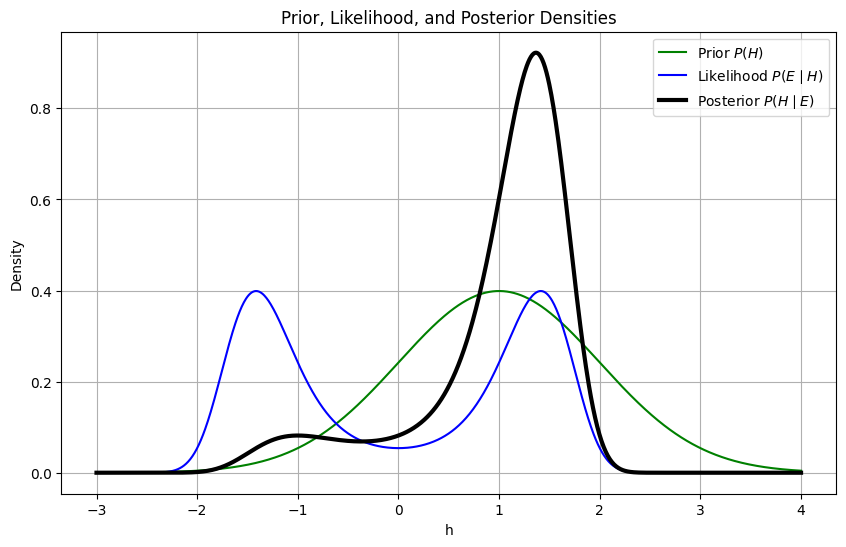

The posterior attains its maximum value at h = 1.365


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def prior(h):
    return norm.pdf(h, 1, 1)

def likelihood(h, e):
    return norm.pdf(e, h**2, 1)

def posterior(h, e):
    unnormalized = likelihood(h, e) * prior(h)
    norm_const = np.trapz(unnormalized, h)
    return unnormalized / norm_const

h = np.linspace(-3, 4, 1000)
e = 2

f_prior = prior(h)
f_likelihood = likelihood(h, e)
f_post = posterior(h, e)

plt.figure(figsize=(10, 6))
plt.plot(h, f_prior, label=r'Prior $P(H)$', color='green')
plt.plot(h, f_likelihood, label=r'Likelihood $P(E\mid H)$', color='blue')
plt.plot(h, f_post, label=r'Posterior $P(H\mid E)$', color='black', linewidth=3)
plt.xlabel('h')
plt.ylabel('Density')
plt.title('Prior, Likelihood, and Posterior Densities')
plt.legend()
plt.grid()
plt.show()

max_post_h = h[f_post.argmax()]
print("The posterior attains its maximum value at h = {:5.3f}".format(max_post_h))


## Task 2

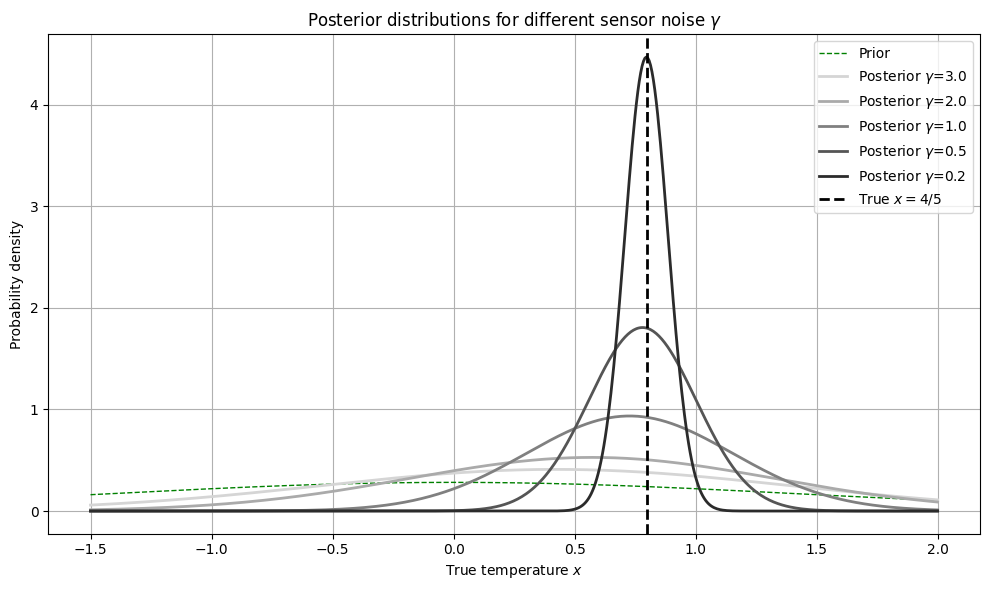

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import cm

A = np.array([[2], [1]])
y = np.array([1, 2])
S0 = 2
m0 = 0

gammas = [3.0, 2.0, 1.0, 0.5, 0.2]

x_vals = np.linspace(-1.5, 2.0, 600)

cmap = plt.get_cmap('gist_grey_r', len(gammas)+2)
colors = [cmap(i+1) for i in range(len(gammas))]

plt.figure(figsize=(10, 6))

prior = norm.pdf(x_vals, loc=m0, scale=np.sqrt(S0))
plt.plot(x_vals, prior, color='green', lw=1, linestyle='--', label="Prior")

for idx, gamma in enumerate(gammas):
    S0_inv = 1 / S0
    Sigma_inv = np.eye(2) / (gamma ** 2)
    At_Sinv_A = A.T @ Sigma_inv @ A
    S_post = 1 / (S0_inv + At_Sinv_A[0, 0])
    m_post = S_post * (S0_inv * m0 + (A.T @ Sigma_inv @ y)[0])
    posterior = norm.pdf(x_vals, loc=m_post, scale=np.sqrt(S_post))
    plt.plot(
        x_vals, posterior, color=colors[idx], lw=2,
        label=fr"Posterior $\gamma$={gamma}"
    )

plt.axvline(0.8, color='black', linestyle='--', lw=2, label="True $x=4/5$")
plt.title(r"Posterior distributions for different sensor noise $\gamma$")
plt.xlabel("True temperature $x$")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Task 3

- Initialize the chain at some value for $\mu$, say $\mu_{\text{current}}$.
- Propose a new value $\mu_{\text{proposal}}$ by sampling from a normal distribution centered at $\mu_{\text{current}}$ with some proposal width.
- Compute the acceptance probability:
   $
   p_{\text{accept}} = \min\left(1, \frac{P(x \mid \mu_{\text{proposal}}) P(\mu_{\text{proposal}})}{P(x \mid \mu_{\text{current}}) P(\mu_{\text{current}})}\right)
   $
- Accept or reject the proposal:
    - Accept the new value with probability $p_{accept}$.
    - If accepted, set $\mu_{\text{current}} = \mu_{\text{proposal}}$; otherwise, stay at $\mu_{\text{current}}$.
- Repeat steps 2–4 for many iterations to build up a chain of samples



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

rng = np.random.default_rng(42)
n = 20
sigma = 15
mu_prior = 130
sigma_prior = 15

true_mu = 125
x = rng.normal(true_mu, sigma, size=n)

sigma_post_sq = 1 / (1/sigma_prior**2 + n/sigma**2)
mu_post = sigma_post_sq * (mu_prior/sigma_prior**2 + x.sum()/sigma**2)
sigma_post = np.sqrt(sigma_post_sq)

def log_posterior(mu, data, mu_prior, sigma_prior, sigma):
    lp = norm.logpdf(mu, mu_prior, sigma_prior)
    ll = np.sum(norm.logpdf(data, mu, sigma))
    return lp + ll

def metropolis_mcmc(log_posterior, data, mu_prior, sigma_prior, sigma, n_samples=10000, proposal_width=3.0, rng=None):
    samples = np.empty(n_samples)
    mu_current = np.mean(data)
    logp_current = log_posterior(mu_current, data, mu_prior, sigma_prior, sigma)
    n_accept = 0
    for i in range(n_samples):
        mu_proposal = rng.normal(mu_current, proposal_width)
        logp_proposal = log_posterior(mu_proposal, data, mu_prior, sigma_prior, sigma)
        log_accept_ratio = logp_proposal - logp_current
        if np.log(rng.uniform()) < log_accept_ratio:
            mu_current = mu_proposal
            logp_current = logp_proposal
            n_accept += 1
        samples[i] = mu_current
    acceptance_rate = n_accept / n_samples
    return samples, acceptance_rate


**Changing Proposal Width**

- **Decreasing proposal_width (narrower proposals):**
  - The sampler will propose new values very close to the current value.
  - This leads to a high acceptance rate, but the chain moves slowly through the parameter space (poor *mixing*), potentially requiring many more samples to adequately explore the posterior
  - The chain can become highly autocorrelated, reducing the effective sample size

- **Increasing proposal_width (wider proposals):**
  - The sampler proposes values farther from the current value.
  - This can decrease the acceptance rate, as proposals often land in low-probability regions and are rejected.
  - If too wide, the chain can get "stuck" for long periods, again reducing efficiency and potentially biasing results.

- **Optimal proposal width:**
  - There is a "Goldilocks" region where the proposal width is neither too small nor too large, leading to good mixing and an efficient exploration of the posterior.
  - A common rule of thumb is to tune the proposal width so that the acceptance rate is around 20–50%, often aiming for about 0.234 in high dimensions or 40–50% in one dimension.

**Changing Burn-in**

- **Decreasing burn-in (shorter burn-in):**
  - If the burn-in period is too short, samples may still be influenced by the arbitrary starting value and not yet representative of the true posterior.
  - This can bias your estimates, especially if the chain takes a while to converge to the stationary distribution.

- **Increasing burn-in (longer burn-in):**
  - Discards more of the initial samples, ensuring that only samples from the stationary distribution are used for inference.
  - However, setting burn-in much longer than necessary simply wastes samples and computational effort.

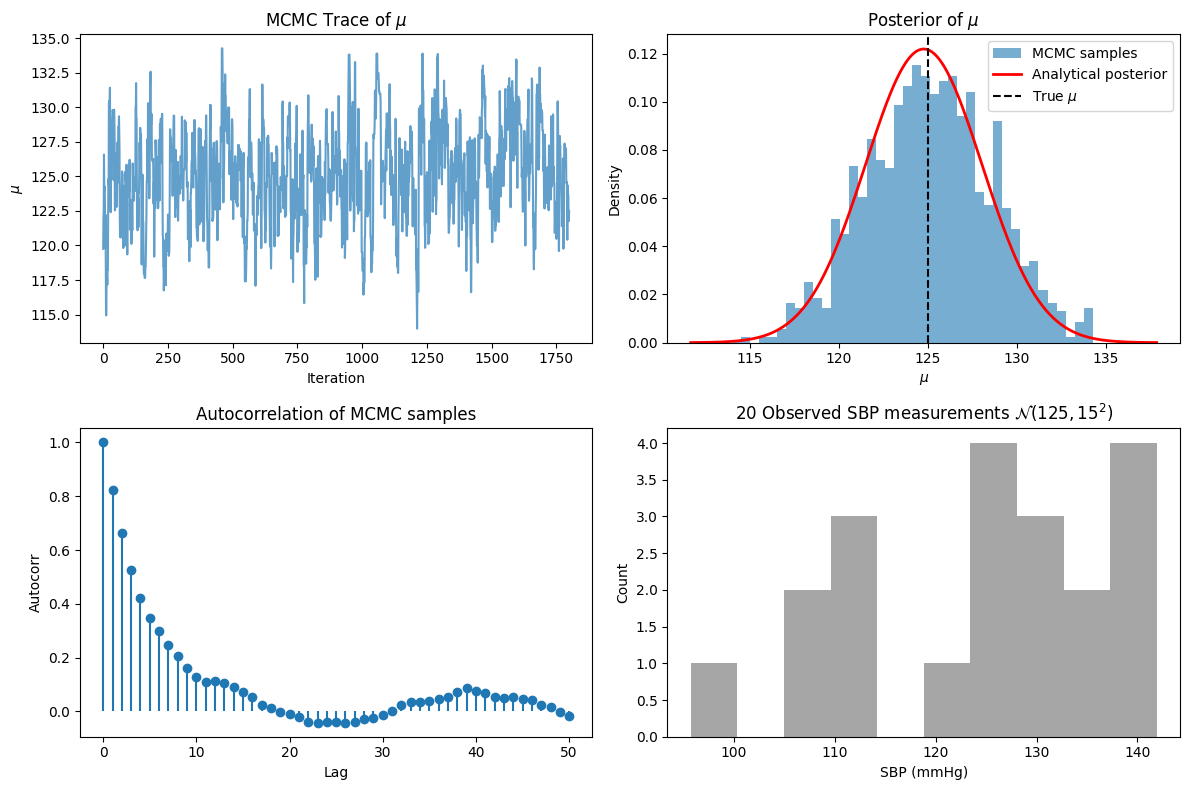

Analytical posterior mean: 124.77, std: 3.27
MCMC posterior mean: 125.10, std: 3.52
True mean used for simulation: 125.00
Acceptance ratio: 72.85%


In [4]:
proposal_width = 3.0

mcmc_samples, n_accept_ratio = metropolis_mcmc(
    log_posterior,
    x,
    mu_prior,
    sigma_prior,
    sigma,
    n_samples=2000,
    proposal_width=proposal_width,
    rng=rng
)
burn_in = 200
mcmc_samples = mcmc_samples[burn_in:]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(mcmc_samples, alpha=0.7)
axes[0,0].set_title(r"MCMC Trace of $\mu$")
axes[0,0].set_xlabel("Iteration")
axes[0,0].set_ylabel(r"$\mu$")

mu_grid = np.linspace(mu_post - 4*sigma_post, mu_post + 4*sigma_post, 500)
axes[0,1].hist(mcmc_samples, bins=40, density=True, alpha=0.6, label="MCMC samples")
axes[0,1].plot(mu_grid, norm.pdf(mu_grid, mu_post, sigma_post), 'r-', lw=2, label="Analytical posterior")
axes[0,1].axvline(true_mu, color='k', ls='--', label=r"True $\mu$")
axes[0,1].set_title(r"Posterior of $\mu$")
axes[0,1].set_xlabel(r"$\mu$")
axes[0,1].set_ylabel("Density")
axes[0,1].legend()

def autocorr(x, max_lag=50):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    acorr = result[result.size // 2:]
    acorr /= acorr[0]
    return acorr[:max_lag+1]

lags = np.arange(51)
ac = autocorr(mcmc_samples, max_lag=50)
axes[1,0].stem(lags, ac, basefmt=" ")
axes[1,0].set_title("Autocorrelation of MCMC samples")
axes[1,0].set_xlabel("Lag")
axes[1,0].set_ylabel("Autocorr")

axes[1,1].hist(x, bins=10, color='gray', alpha=0.7)
axes[1,1].set_title(r"20 Observed SBP measurements $\mathcal{N}(125, 15^2)$")
axes[1,1].set_xlabel("SBP (mmHg)")
axes[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Analytical posterior mean: {mu_post:.2f}, std: {sigma_post:.2f}")
print(f"MCMC posterior mean: {np.mean(mcmc_samples):.2f}, std: {np.std(mcmc_samples):.2f}")
print(f"True mean used for simulation: {true_mu:.2f}")
print(f"Acceptance ratio: {100*n_accept_ratio:.2f}%")


A trace diagram (or trace plot) in MCMC: line plot showing the sampled values of a parameter (e.g., $\mu$) over the course of the Markov chain iterations. 

- **Convergence**: check whether the chain has "forgotten" its starting value and settled into sampling from the target (posterior) distribution (fluctuating without long-term trends = good).
- **Burn-in**: shows when the chain is moving from its starting value to the main region of interest (determine how many initial samples to remove).
- **Mixing**: chain moving up and down rapidly = exploring the parameter space efficiently. Poor mixing is seen as the chain getting "stuck" or moving slowly, which suggests high autocorrelation and inefficiency.

**Autocorrelation**: how each sample in the chain is correlated with previous samples at a given lag.

**effective sample size (ESS)**: how many independent samples your correlated MCMC chain is equivalent to. Because MCMC samples are typically autocorrelated, the ESS is always less than or equal to the actual number of samples. 

| Step                     | Formula/Description                                                                 |
|--------------------------|-------------------------------------------------------------------------------------|
| Sample mean              | $$ \hat{\mu} = \frac{1}{N} \sum_{n=1}^N x_n $$                                     |
| Autocovariance           | $$ \hat{C}(t) = \frac{1}{N-t} \sum_{n=1}^{N-t} (x_{n+t} - \hat{\mu})(x_n - \hat{\mu}) $$ |
| Autocorrelation          | $$ \rho(t) = \frac{\hat{C}(t)}{\hat{C}(0)} $$                                      |
| Integrated autocorr. time| $$ \tau_{\text{int}} = 1 + 2 \sum_{t=1}^{T} \rho(t) $$                             |
| ESS      | $$ \frac{N}{1 + 2 \sum_{t=1}^{\infty} \rho_t} $$ (sum is truncated at a lag where autocorrelations become negligible) |

Integrated autocorrelation time (IACT): 10.77
Effective sample size (ESS): 167.1 out of 1800 samples


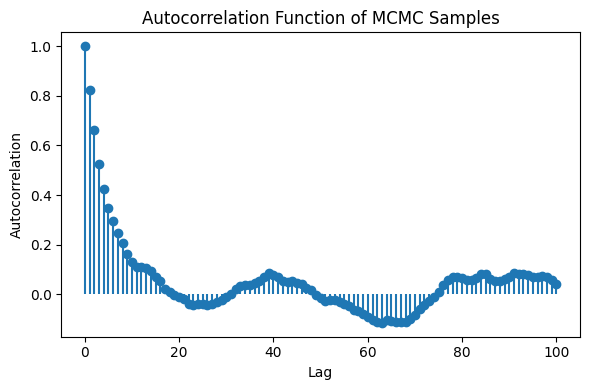

In [5]:
def autocorr(x, max_lag=100):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    acorr = result[result.size // 2:]
    acorr /= acorr[0]
    return acorr[:max_lag+1]

def integrated_autocorr_time(acorr):
    return 1 + 2 * np.sum(acorr[1:])

def effective_sample_size(n_samples, iact):
    return n_samples / iact

max_lag = 100
ac = autocorr(mcmc_samples, max_lag=max_lag)
iact = integrated_autocorr_time(ac)
ess = effective_sample_size(len(mcmc_samples), iact)

print(f"Integrated autocorrelation time (IACT): {iact:.2f}")
print(f"Effective sample size (ESS): {ess:.1f} out of {len(mcmc_samples)} samples")

fig, ax = plt.subplots(figsize=(6, 4))
ax.stem(range(max_lag+1), ac, basefmt=" ")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function of MCMC Samples")
plt.tight_layout()
plt.show()


- IACT: On average, it takes about 8.3 MCMC steps before the chain produces a sample that is nearly independent of the previous ones. The lower the IACT, the less correlated your samples are.
- ESS: Although you have 18,000 MCMC samples, their autocorrelation means they are only as informative as about 2,168 independent samples. The higher the ESS relative to the total samples, the better.